# CSE 519 -- Data Science (Fall 2018) 
# Homework 2: Exploratory Data Analysis in iPython

## New York City Taxi Fare Prediction
## Md Majid Jahangir - SBU ID 112077145


### Setting up the libraries and packages and global variables

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy import distance
from sklearn.metrics.pairwise import paired_distances
from scipy.stats.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
plt.style.use('seaborn-whitegrid')

trainingDF = None      #training data
testDF = None          #test data
validateData = None    #validate data

### Methods to load training, test and validate data

In [ ]:
#method to load train data in dataframe
def loadTrainingData():
    global trainingDF 
    trainingDF = pd.read_csv('train.csv',nrows=(5000000+50000))  
    
#method to load data to get error metrics, 50000 rows of the 5000000 train dataset 
def loadValidateData():
    global validateData
    global trainingDF
    validateData = trainingDF[5000001:]
    trainingDF = trainingDF[:5000000]
    
#method to load test data
def loadTestData():
    global testDF
    testDF = pd.read_csv('test.csv')

In [ ]:
loadTrainingData()  
loadTestData()
loadValidateData()

### Describing on test and training data to look at some statistics

In [4]:
testDF.describe()
trainingDF.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.000000e+06,5.000000e+06,5.000000e+06,4.999964e+06,4.999964e+06,5.000000e+06
mean,1.134080e+01,-7.250678e+01,3.991974e+01,-7.250652e+01,3.991725e+01,1.684695e+00
std,9.820175e+00,1.280970e+01,8.963509e+00,1.284777e+01,9.486767e+00,1.331854e+00
min,-1.000000e+02,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399206e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076712e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,3.310364e+03,3.457622e+03,3.345917e+03,2.080000e+02


In [5]:
trainingDF.head(2)     #checking the format of data

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1


## Cleaning of Data

In [6]:
def drop_null_values(df):
    print(df.isnull().sum())    #finding any NaN or null values in the data
    df = df.dropna(how = 'any', axis = 'rows')       #dropping off rows with NaN values from train set

### Also, from train data describe, we saw the max passenger count as great as 208. As per NYC Taxi and Limousine Commission rule, max 6 people can board a taxi at a time. Hence dropping any rows with count > 6 and < 1

In [7]:
def clean_passenger_column(df):
    df = df.drop(df[df['passenger_count']<1].index, axis = 0)
    df = df.drop(df[df['passenger_count']>6].index, axis = 0)


### Adding two features 'absolute difference of latitude" and "absolute difference of longitude"

In [8]:
#finding Manhattan vector and adding as a feature in the dataframe to find possible outliers as the pearson coefficent turned out to be very bad
def add_Manhattan_vector_feature(trainingDF):
    trainingDF['abs_diff_long'] = (trainingDF.dropoff_longitude - trainingDF.pickup_longitude).abs()
    trainingDF['abs_diff_lat'] = (trainingDF.dropoff_latitude - trainingDF.pickup_latitude).abs()

### dropping off rows which has absolute difference of latitude more than 4.2 as New York state width is approx. 285 miles dropping off rows which has absolute difference of longitude more than  as New York state length is approx. 330 miles as one latitude and longitude difference equals ~69 and ~55 miles respectively

In [9]:
def remove_outliers_from_manhattan_distance(df):
    df = df.drop(df[df['abs_diff_long']>=5.0].index, axis = 0)
    df = df.drop(df[df['abs_diff_lat']>=4.2].index, axis = 0)

### Bounding our train data by the max. and min. bounds of pick up and drop off latitudes and longitudes of test data as  that's the range with which we will check against.

In [10]:
def bound_train_data_basedon_test_data():
    test_data_lat_range= min(testDF.pickup_latitude.min(), testDF.dropoff_latitude.min()),max(testDF.pickup_latitude.max(), testDF.dropoff_latitude.max())
    test_data_long_range = min(testDF.pickup_longitude.min(), testDF.dropoff_longitude.min()), max(testDF.pickup_longitude.max(), testDF.dropoff_longitude.max())
    test_data_range = (test_data_long_range,test_data_lat_range)
    return test_data_range

In [11]:
#bounding on train data using the above bounds
def bound_data_based_on_test_data():
    global trainingDF
    global validateData
    test_data_range = bound_train_data_basedon_test_data()
    trainingDF = trainingDF[(trainingDF['pickup_latitude']>=test_data_range[1][0]) & (trainingDF['pickup_latitude']<=test_data_range[1][1]) &  
                (trainingDF['dropoff_latitude']>=test_data_range[1][0]) & (trainingDF['dropoff_latitude']<=test_data_range[1][1])
                        & (trainingDF['pickup_longitude']<=test_data_range[0][1]) & 
                (trainingDF['dropoff_longitude']<=test_data_range[0][1]) & (trainingDF['dropoff_longitude']>=test_data_range[0][0]) & 
                        (trainingDF['pickup_longitude']>=test_data_range[0][0])]
    validateData = validateData[(validateData['pickup_latitude']>=test_data_range[1][0]) & (validateData['pickup_latitude']<=test_data_range[1][1]) &  
                (validateData['dropoff_latitude']>=test_data_range[1][0]) & (validateData['dropoff_latitude']<=test_data_range[1][1])
                        & (validateData['pickup_longitude']<=test_data_range[0][1]) & 
                (validateData['dropoff_longitude']<=test_data_range[0][1]) & (validateData['dropoff_longitude']>=test_data_range[0][0]) & 
                        (validateData['pickup_longitude']>=test_data_range[0][0])]

In [12]:
#let's us describe the data again
trainingDF.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.000000e+06,5.000000e+06,5.000000e+06,4.999964e+06,4.999964e+06,5.000000e+06
mean,1.134080e+01,-7.250678e+01,3.991974e+01,-7.250652e+01,3.991725e+01,1.684695e+00
std,9.820175e+00,1.280970e+01,8.963509e+00,1.284777e+01,9.486767e+00,1.331854e+00
min,-1.000000e+02,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399206e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076712e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,3.310364e+03,3.457622e+03,3.345917e+03,2.080000e+02


### Adding euclidean distance feature to the dataset

In [13]:
def add_euclidean_distance_feature(df):
    geoloc_pickup_pair = list(zip(df.pickup_latitude, df.pickup_longitude))
    geoloc_dropoff_pair = list(zip(df.dropoff_latitude, df.dropoff_longitude))
    df['euc_distance'] = paired_distances(geoloc_pickup_pair, geoloc_dropoff_pair)

### From data describe we saw there were negative fares and also, we know NY lies above equator and west of Prime meridian because of which the valid latitude and longitude range becomes (0,90) and (-180,0) respectively. We drop off such rows with invalid range of data.

In [14]:
def drop_all_outliers_of_params(df):
    df = df.drop(((df[df.fare_amount<0]) | (df[df.pickup_latitude<0])| (df[df['pickup_latitude']>90]) | (df[df['dropoff_latitude']<0]) | (df[df['dropoff_latitude']>90]) | (df[df['pickup_longitude']>0]) | (df[df['pickup_longitude']<-180]) | (df[df['dropoff_longitude']>0]) | (df[df['dropoff_longitude']<-180]) | (df[df.fare_amount>100])).index, axis=0)

### Adding haversine distance feature to train data

In [15]:
#method to compute haversine distance in miles between 2 coordinates - taken from stackoverflow
def haversine_distance(lat1, long1, lat2, long2,df):
    data = [df]
    for i in data:
        p = 0.017453292519943295 
        a = 0.5 - np.cos((i[lat2] - i[lat1]) * p)/2 + np.cos(i[lat1] * p) * np.cos(i[lat2] * p) * (1 - np.cos((i[long2] - i[long1]) * p)) / 2
        i['haversine_distance'] =  0.6213712 * 12742 * np.arcsin(np.sqrt(a))

### Parsing 'pickup_datetime' field as a date field and adding time features

In [16]:
def parse_dates_and_add_time_features(df,field,format1):
    df[field] = pd.to_datetime(df[field],format=format1)
    train_data = [df]
    for row in train_data:
        row['year'] = row[field].dt.year
        row['month'] = row[field].dt.month
        row['date'] = row[field].dt.day
        row['day_of_week'] = row[field].dt.dayofweek
        row['hour'] = row[field].dt.hour
        row['quarter'] = row[field].dt.quarter
        row['sec'] = row[field].dt.second

### Removing rows which has fare lesser than 2.5 USD because as per NYC Taxi and Limousine Commission that is the minimum base fare available.

In [17]:
trainingDF=trainingDF[trainingDF.fare_amount>=2.5]     #todo

### Creating a pickup heatmap scatter plot to visualise the hotspots for pickup

<Figure size 3600x2160 with 0 Axes>

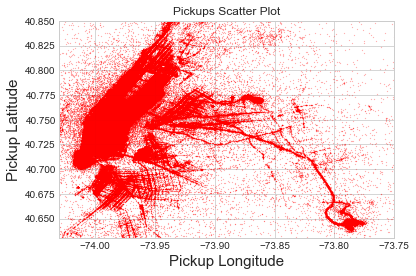

In [54]:
plt.figure(figsize=(50,30))
trainingDF.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='red', 
                s=.03, alpha=.7)
plt.title("Pickups Scatter Plot")
long_border = (-74.03, -73.75)
lat_border = (40.63, 40.85)
plt.ylim(lat_border)
plt.xlim(long_border)
plt.xlabel('Pickup Longitude', size=15)
plt.ylabel('Pickup Latitude',size=15)
plt.savefig('pickup scatter.png')

### Generating features classifying data entries as pickup and drop off regions for 3 airports in NY

In [41]:
airports={'JFK':{'min_long':-73.8352,
     'min_lat':40.6195,
     'max_long':-73.7401, 
     'max_lat':40.6659},
              
    'EWR':{'min_long':-74.1925,
            'min_lat':40.6700, 
            'max_long':-74.1531, 
            'max_lat':40.7081

        },
    'LaG':{'min_long':-73.8895, 
                  'min_lat':40.7664, 
                  'max_long':-73.8550, 
                  'max_lat':40.7931
        
    }
    
}
def isAirport(lat,long,airport_name='JFK'):
    latMinTrue = (lat>=airports[airport_name]['min_lat'] )
    latMaxTrue = (lat<=airports[airport_name]['max_lat'])
    longMinTrue = (long>=airports[airport_name]['min_long'])
    longMaxTrue = (long<=airports[airport_name]['max_long'])
    #result = np.where( ((latitude>=nyc_airports[airport_name]['min_lat']) & (latitude<=nyc_airports[airport_name]['max_lat']) & (longitude>=nyc_airports[airport_name]['min_lng']) & (longitude<=nyc_airports[airport_name]['max_lng'])), 1, 0) 
    if latMinTrue and latMaxTrue and longMinTrue and longMaxTrue:
        return 1
    else:
        return 0
    return 0
    
def categorise_airport_feature(df):
    data = [df]
    for index,row in df.iterrows():
        row['is_pickup_JFK']=isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK')
        row['is_dropoff_JFK']=isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK')
        row['is_pickup_EWR']=isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR')
        row['is_dropoff_EWR']=isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR')
        row['is_dropoff_lag']=isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaG')
        row['is_pickup_lag']=isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaG')

### Cleaning all the data based on above stated factors

In [20]:
drop_null_values(trainingDF)
drop_null_values(validateData)
clean_passenger_column(trainingDF)
clean_passenger_column(validateData)
drop_all_outliers_of_params(validateData)
bound_data_based_on_test_data()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    36
dropoff_latitude     36
passenger_count       0
dtype: int64
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


### Adding features described above

In [ ]:
add_Manhattan_vector_feature(trainingDF)
add_Manhattan_vector_feature(validateData)
add_Manhattan_vector_feature(testDF)
add_euclidean_distance_feature(trainingDF)
add_euclidean_distance_feature(testDF)
add_euclidean_distance_feature(validateData)
drop_all_outliers_of_params(trainingDF)
haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', trainingDF)
haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', testDF)
haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', validateData)
parse_dates_and_add_time_features(trainingDF,'pickup_datetime',"%Y-%m-%d %H:%M:%S UTC")
parse_dates_and_add_time_features(testDF,'pickup_datetime',"%Y-%m-%d %H:%M:%S UTC")
parse_dates_and_add_time_features(validateData,'pickup_datetime',"%Y-%m-%d %H:%M:%S UTC")

#Adding feature column
trainingDF['is_pickup_JFK'] = 0
trainingDF['is_dropoff_JFK'] = 0
trainingDF['is_pickup_EWR'] = 0
trainingDF['is_dropoff_EWR'] = 0
trainingDF['is_dropoff_lag'] = 0
trainingDF['is_pickup_lag'] = 0
testDF['is_pickup_JFK'] = 0
testDF['is_dropoff_JFK'] = 0
testDF['is_pickup_EWR'] = 0
testDF['is_dropoff_EWR'] = 0
testDF['is_dropoff_lag'] = 0
testDF['is_pickup_lag'] = 0
validateData['is_pickup_JFK'] = 0
validateData['is_dropoff_JFK'] = 0
validateData['is_pickup_EWR'] = 0
validateData['is_dropoff_EWR'] = 0
validateData['is_dropoff_lag'] = 0
validateData['is_pickup_lag'] = 0
categorise_airport_feature(testDF)
categorise_airport_feature(trainingDF)
categorise_airport_feature(validateData)

### Using external dataset to add a feature 'is_holiday'

In [ ]:
#Holiday for USA dataset from 2010-2020. Source - https://data.world/jennifer-v/us-holiday-dates-2010-2020. Attaching it here in the zip folder
holidayList = pd.read_csv('holidaydatelist.csv')
holidayList.describe()
holidayList.head(2)
holidayList = holidayList[['day_date']]
parse_dates_and_add_time_features(holidayList, 'day_date',"%Y-%m-%d")
holidayList = holidayList.dropna(how = 'any', axis = 'rows')     
def add_is_holiday_feature(df1,df2):
    df1['is_holiday'] = 0
    date = list(df2.date)    
    year = list(df2.year)
    month = list(df2.month)
    for index,row in df1.iterrows():
        for i in range(len(date)):
            if row.date==date[i] and row.month==month[i]:
                row['is_holiday'] = 1
add_is_holiday_feature(trainingDF,holidayList)
add_is_holiday_feature(testDF,holidayList)
add_is_holiday_feature(validateData,holidayList)

Text(0,0.5,'Absolute Latitude Difference')

<Figure size 3600x2160 with 0 Axes>

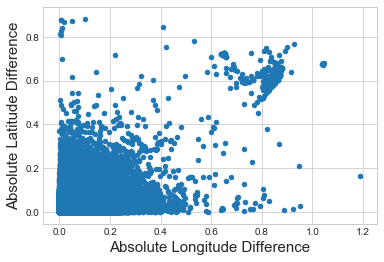

In [55]:
#plotting the scatter plot to see if there are any outliers
plt.figure(figsize=(50,30))
plot = trainingDF.iloc[:].plot.scatter('abs_diff_long', 'abs_diff_lat')
plt.xlabel('Absolute Longitude Difference', size=15)
plt.ylabel('Absolute Latitude Difference',size=15)

In [23]:
remove_outliers_from_manhattan_distance(trainingDF)
remove_outliers_from_manhattan_distance(validateData)

### Since dataset is huge, let's try our first model by directly removing any distance value = 0, then later in further models we will try to impute those 0 values if it will be possible

In [24]:
trainingDF = trainingDF.drop(trainingDF[trainingDF['haversine_distance']<=0].index, axis = 0)

In [25]:
#method to compute Pearson coefficient
def find_Pearson_coeeificent(df,x,y):
    corr, p_value = pearsonr(df[x], df[y])
    return corr

In [26]:
find_Pearson_coeeificent(trainingDF, 'hour','fare_amount')        #Solution to 2.c of assignment

-0.017046104190507432

### Plotting graphs to show relation between the above 2 variables

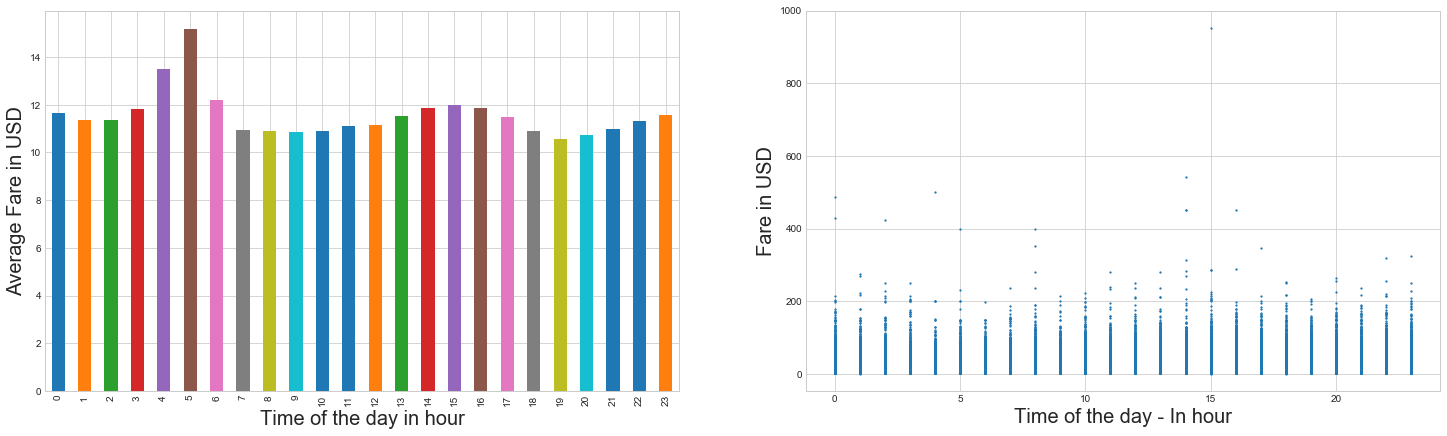

In [53]:
plt.figure(figsize=(25,7))
#plot = trainingDF.iloc[:].plot.scatter('haversine_distance', 'fare_amount')
#plt.rc('font', family='serif', size=1)
aggregate=trainingDF.groupby(['hour'])['fare_amount'].agg('mean')
plt.subplot(1, 2, 1)
gr = aggregate.plot(kind='bar')
gr.set_ylabel("Average Fare in USD", size = 20)
gr.set_xlabel("Time of the day in hour",size=20)

plt.subplot(1, 2, 2)

#plt.rc('font', family='serif', size=40)
plt.scatter(x=trainingDF['hour'], y=trainingDF['fare_amount'], s=1.5)
plt.xlabel('Time of the day - In hour', size=20)
plt.ylabel('Fare in USD',size=20)
plt.savefig('fare vs time of day.png')

In [29]:
find_Pearson_coeeificent(trainingDF, 'fare_amount','haversine_distance')  

0.8333702568239763

In [60]:
find_Pearson_coeeificent(trainingDF, 'hour','euc_distance')

-0.028565521465992692

### Plotting the chart to visualise relation between hour and euclidean distance

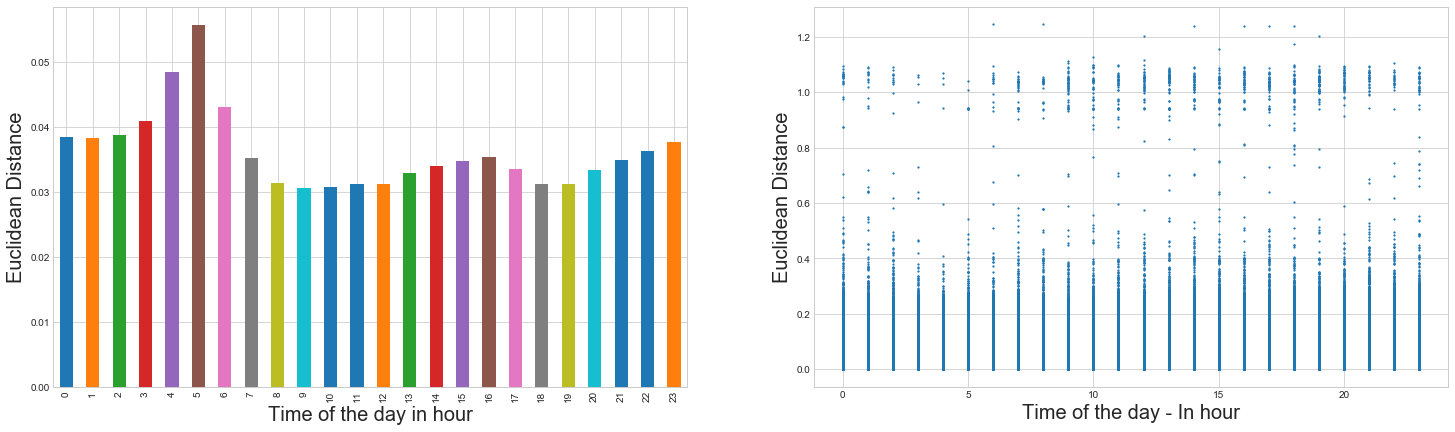

In [63]:
plt.figure(figsize=(25,7))
aggregate=trainingDF.groupby(['hour'])['euc_distance'].agg('mean')
plt.subplot(1, 2, 1)
gr = aggregate.plot(kind='bar')
gr.set_ylabel("Euclidean Distance", size = 20)
gr.set_xlabel("Time of the day in hour",size=20)

plt.subplot(1, 2, 2)

#plt.rc('font', family='serif', size=40)
plt.scatter(x=trainingDF['hour'], y=trainingDF['euc_distance'], s=1.5)
plt.xlabel('Time of the day - In hour', size=20)
plt.ylabel('Euclidean Distance',size=20)
plt.savefig('distance vs time.png')

Text(0,0.5,'Fare')

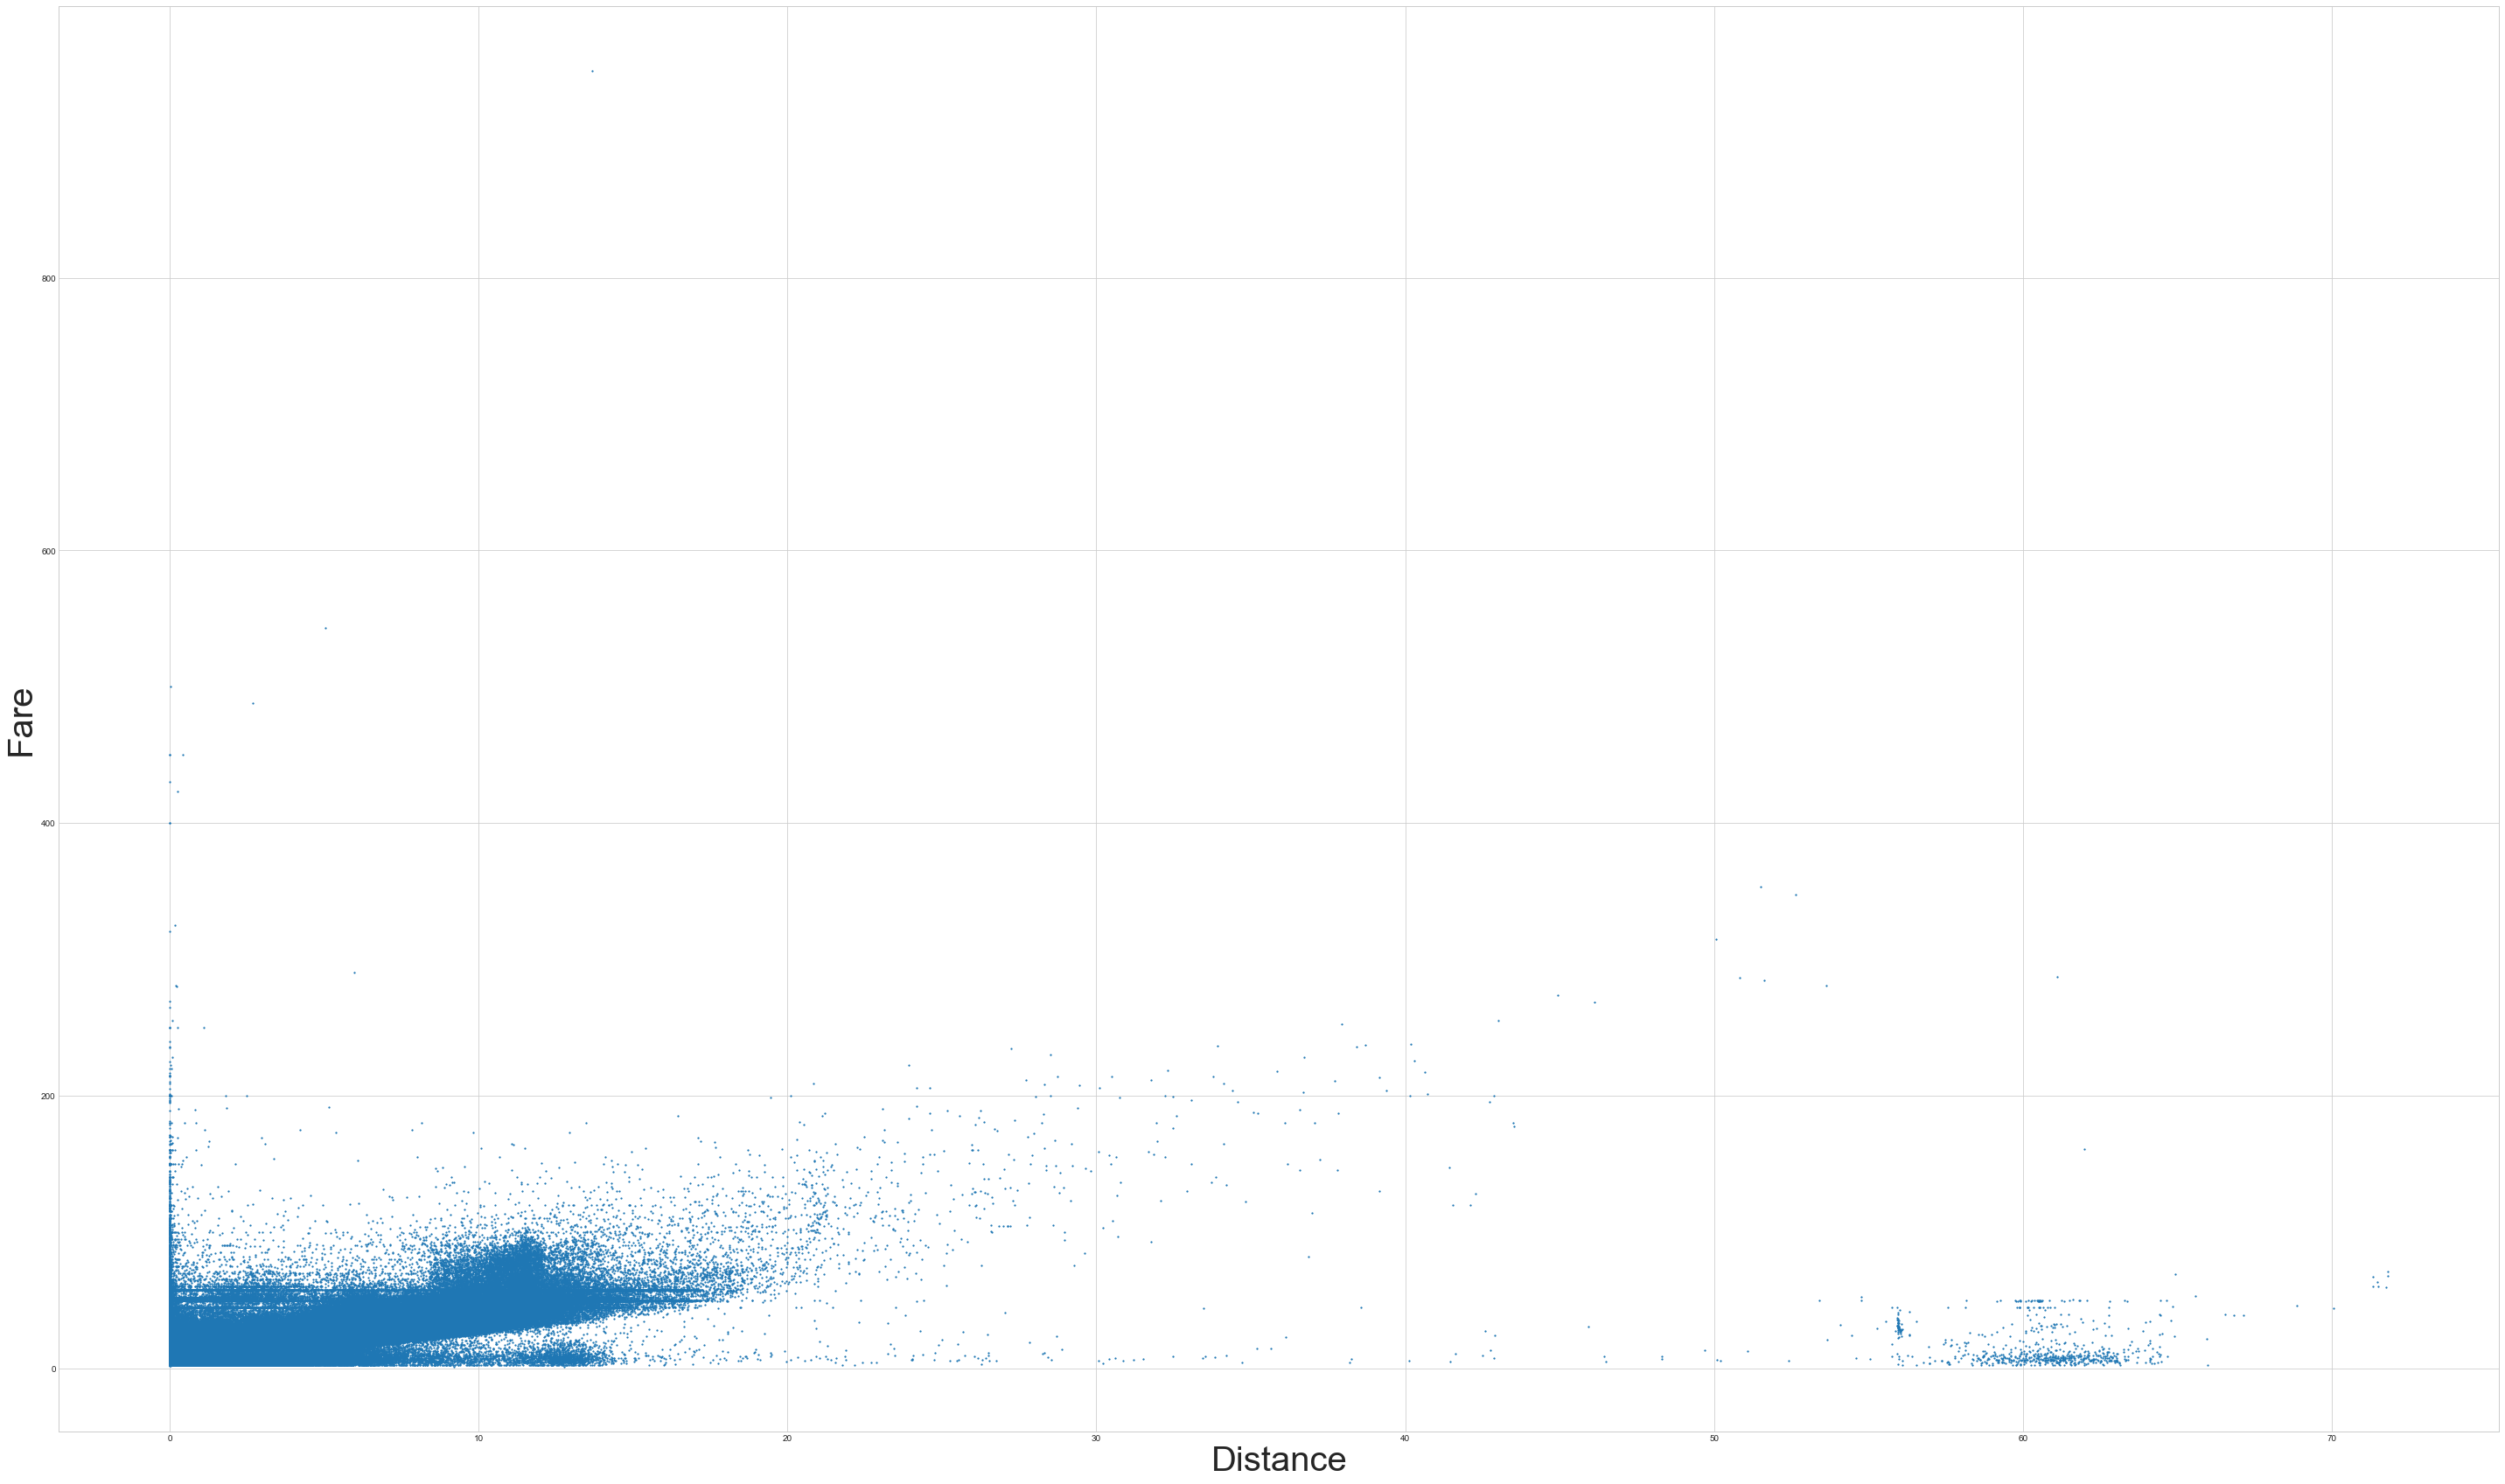

In [46]:
#Plotting relation between distance and fare amount
plt.figure(figsize=(50,30))
plt.scatter(x=trainingDF['haversine_distance'], y=trainingDF['fare_amount'], s=1.5)
plt.xlabel('Distance', size = 40)
plt.ylabel('Fare', size = 40)

In [27]:
find_Pearson_coeeificent(trainingDF, 'hour','euc_distance')        #Solution to 2.b of assignment

-0.028565521465992692

In [28]:
find_Pearson_coeeificent(trainingDF, 'euc_distance','fare_amount')  #Solution to 2.a of assignment

0.8415478510506471

### Seems to be a linear relation with fares, with fares increasing with distance, also there are some outliers in fares which we should take care of.

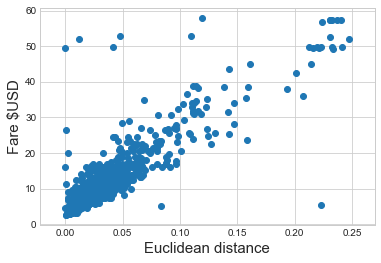

<Figure size 432x288 with 0 Axes>

In [57]:
#plotting the relation between euclidean distance and fare_amount feature

plt.scatter(trainingDF['euc_distance'][:1000], trainingDF['fare_amount'][:1000])
plt.xlabel('Euclidean distance', size=15)
plt.ylabel('Fare $USD', size=15)
plt.show()
plt.savefig('euclidean_Distance_vs_fare_amount.png')

## Modelling our data 

### Basic Linear regression Model

In [58]:
#creating input features to feed into model
def create_input_features(df):
    return np.column_stack((df.is_pickup_JFK,df.is_dropoff_JFK, df.is_dropoff_EWR, df.is_pickup_EWR, df.is_pickup_lag,df.is_dropoff_lag,df.pickup_longitude, df.pickup_latitude, df.dropoff_longitude, df.dropoff_latitude, df.passenger_count, df.abs_diff_long,df.abs_diff_lat,df.haversine_distance, df.day_of_week, df.hour, df.year, np.ones(len(df))))

trainingData_X = create_input_features(trainingDF)
trainingData_Y = np.array(trainingDF.fare_amount)

In [59]:
#taken from Kaggle starter notebook
(weight, _, _, _) = np.linalg.lstsq(trainingData_X, trainingData_Y, rcond = None)
print(weight)

[ 0.00000000e+00  5.54334356e-13 -2.04725126e-12  1.10422782e-12
  1.23989707e-12 -6.76347867e-13  3.40672560e+00 -2.00565423e+01
 -1.50680011e+00 -8.64900760e+00  3.85974645e-02 -1.17641164e+02
 -2.53573743e+02  7.19151321e+00 -5.12348803e-02  1.23855793e-02
  5.24400463e-01  2.59764048e+02]


### Running the model

In [64]:
test_X = create_input_features(testDF)
# Predict fare_amount on the test set using our model (w) trained on the training set.
test_y_predictions = np.matmul(test_X, weight).round(decimals = 2)

In [ ]:
# Write the predictions to a CSV file which we can submit to the competition.

def write_to_submission_csv(prediction):
    global testDF
    submission = pd.DataFrame(
    {'key': testDF.key, 'fare_amount': prediction},
    columns = ['key', 'fare_amount'])
    submission.to_csv('submission.csv', index = False)


In [ ]:
write_to_submission_csv(test_y_predictions)

### Using Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(max_depth=30)
rf.fit(trainingData_X, trainingData_Y)
rf_predict = rf.predict(test_X)
write_to_submission_csv(rf_predict)

In [65]:
import lightgbm as lgbm

params = {

        'max_depth': 10   
    }

train_set = lgbm.Dataset(trainingData_X, trainingData_Y, silent=True)
model = lgbm.train(params, train_set = train_set, num_boost_round=300)
pred_test_y = model.predict(test_X, num_iteration = model.best_iteration)
submission = pd.DataFrame(
    {'key': testDF.key, 'fare_amount': pred_test_y},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)

## Error Metrics

#### Error metrics for Linear Regression

In [ ]:
#Calculating RMSE
test_X = create_input_features(validateData)
# Predict fare_amount on the test set using our model (w) trained on the training set.
test_y_predictions = np.matmul(test_X, weight).round(decimals = 2)
rmse = sqrt(mean_squared_error(validateData.fare_amount, test_y_predictions))
rmse

#### Error Metrics for RandomRegressor LGBM

In [ ]:
#Calculating RMSE
test_X = create_input_features(validateData)
# Predict fare_amount on the test set using our model (w) trained on the training set.
pred_test_y = model.predict(test_X, num_iteration = model.best_iteration)
rmse = sqrt(mean_squared_error(validateData.fare_amount, pred_test_y))
rmse

#### Error metrics for RandomRegressor

In [ ]:
#Calculating RMSE
test_X = create_input_features(validateData)
# Predict fare_amount on the test set using our model (w) trained on the training set.
rf_predict = rf.predict(test_X)
rmse = sqrt(mean_squared_error(validateData.fare_amount, rf_predict))
rmse